# Data Quality Visualizations

In [36]:
import time
import boto3
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import contextily as cx

# Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client("s3")  # for lower-level processes

# Set relative paths to other folders and objects in repository.
BUCKET_NAME = "wecc-historical-wx"
QAQC_DIR = "3_qaqc_wx"
MERGE_DIR = "4_merge_wx"
stations_csv_path = f"s3://{BUCKET_NAME}/{QAQC_DIR}/all_network_stationlist_qaqc.csv"
shapepath = "s3://wecc-historical-wx/0_maps/tl_2021_us_state"

## Map

Next steps:
1. develop categorical color scale of flag rates
2. decide on how to integrate total obs count - normalize rate by obs count or represent as point size
3. how to visualize per-network flag rates - average point location, or region


Maps to generate:
- per station maps within target networks
    - could compare network with internal QAQC (ASOSAWOS) vs one without, of similar size and total observation counts
    - for variables of interest (one variable per map)
- per network maps


In [127]:
# Per-network flag rates tables

network_natv_rates = pd.read_csv(
    f"s3://wecc-historical-wx/{MERGE_DIR}/network_native_flag_rates.csv"
)
network_hrly_rates = pd.read_csv(
    f"s3://wecc-historical-wx/{MERGE_DIR}/network_hourly_flag_rates.csv"
)

In [128]:
# Per-station flag rates tables

station_natv_rates = pd.read_csv(
    f"s3://wecc-historical-wx/{MERGE_DIR}/station_native_flag_rates.csv"
)
station_hrly_rates = pd.read_csv(
    f"s3://wecc-historical-wx/{MERGE_DIR}/station_hourly_flag_rates.csv"
)

In [129]:
station_hrly_rates

,networks,accum_pr,elevation,pr,tas,total_obs_count,pvp,psl,rsds,hurs,tdps_derived,svp,tdps,ps_altimeter,ps,sfcWind_dir,sfcWind,hurs_derived
0,SNOTEL_999,1.0,0.0,0.002058,0.000700,139934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SNOTEL_998,NaN,0.0,0.550021,0.002396,108525.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SNOTEL_993,NaN,0.0,NaN,0.000000,3751.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SNOTEL_992,1.0,0.0,0.000753,0.000608,103604.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SNOTEL_991,1.0,0.0,0.001131,0.001481,185660.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,ASOSAWOS_72025400119,NaN,0.0,0.000180,0.000000,133243.0,NaN,NaN,NaN,NaN,NaN,NaN,0.018538,0.000000,0.000023,0.0,0.002649,0.018538
1284,ASOSAWOS_72020200118,NaN,0.0,0.000000,0.000376,133017.0,NaN,0.0,NaN,NaN,NaN,NaN,0.027260,0.000008,0.000015,0.0,0.002030,0.027636
1285,ASOSAWOS_72019300117,NaN,0.0,0.000000,0.000056,70829.0,NaN,NaN,NaN,NaN,NaN,NaN,0.025696,0.000000,0.000000,0.0,0.021898,0.025752
1286,ASOSAWOS_72012200114,NaN,0.0,NaN,NaN,9776.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,NaN


In [130]:
station_hrly_rates = station_hrly_rates.rename(
    columns={"networks": "era-id"}
)
station_natv_rates = station_natv_rates.rename(columns={"networks": "era-id"})

### Merge with station list

In [131]:
station_list = pd.read_csv(stations_csv_path)
station_list = station_list.drop("elevation", axis=1)

In [132]:
merged_list = station_list.merge(station_natv_rates, on="era-id")

In [133]:
sub_list = merged_list[merged_list["network"] == 'SNOTEL']

In [134]:
sub_list.columns

Index(['Unnamed: 0', 'era-id', 'latitude', 'longitude', 'start-date',
       'end-date', 'pulled', 'time_checked', 'network', 'cleaned',
       'time_cleaned', 'tas_nobs', 'tdps_nobs', 'tdps_derived_nobs', 'ps_nobs',
       'ps_derived_nobs', 'psl_nobs', 'ps_altimeter_nobs', 'pr_nobs',
       'pr_5min_nobs', 'pr_1h_nobs', 'pr_24h_nobs', 'pr_localmid_nobs',
       'hurs_nobs', 'sfcwind_nobs', 'sfcwind_dir_nobs', 'rsds_nobs',
       'total_nobs', 'qaqc', 'time_qaqc', 'elevation', 'hurs', 'pr_1h', 'rsds',
       'sfcWind_dir', 'sfcWind', 'tas', 'tdps_derived', 'total_obs_count',
       'ps', 'pr', 'accum_pr', 'pvp', 'psl', 'svp', 'tdps', 'ps_altimeter',
       'ps_derived', 'accum_pr_24h', 'accum_pr_localmid', 'pr_24h',
       'pr_localmid', 'accum_pr_1h', 'pr_5min', 'accum_pr_5min',
       'pvp_derived'],
      dtype='object')

In [135]:
sub_list['accum_pr'].max()

1.0

In [136]:
map_list = sub_list

# Format dates in datetime format (this gets lost in import).
map_list["start-date"] = pd.to_datetime(map_list["start-date"], utc=True)
map_list["end-date"] = pd.to_datetime(map_list["end-date"], utc=True)

# Make a geodataframe.
gdf = gpd.GeoDataFrame(
    map_list,
    geometry=gpd.points_from_xy(map_list.longitude, map_list.latitude),
)
gdf.set_crs(epsg=4326, inplace=True)  # Set CRS

# Project data to match base tiles.
gdf_wm = gdf.to_crs(epsg=3857)  # Web mercator

# Read in geometry of continental US.
us = gpd.read_file(shapepath)

# Remove territories, AK, HI
rem_list = ["HI", "AK", "MP", "GU", "AS", "PR", "VI"]
us = us.loc[us.STUSPS.isin(rem_list) == False]

# Use to clip stations
us = us.to_crs(epsg=3857)
gdf_us = gdf_wm.clip(us)


/tmp/ipykernel_1099/3185178280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_list["start-date"] = pd.to_datetime(map_list["start-date"], utc=True)
/tmp/ipykernel_1099/3185178280.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_list["end-date"] = pd.to_datetime(map_list["end-date"], utc=True)


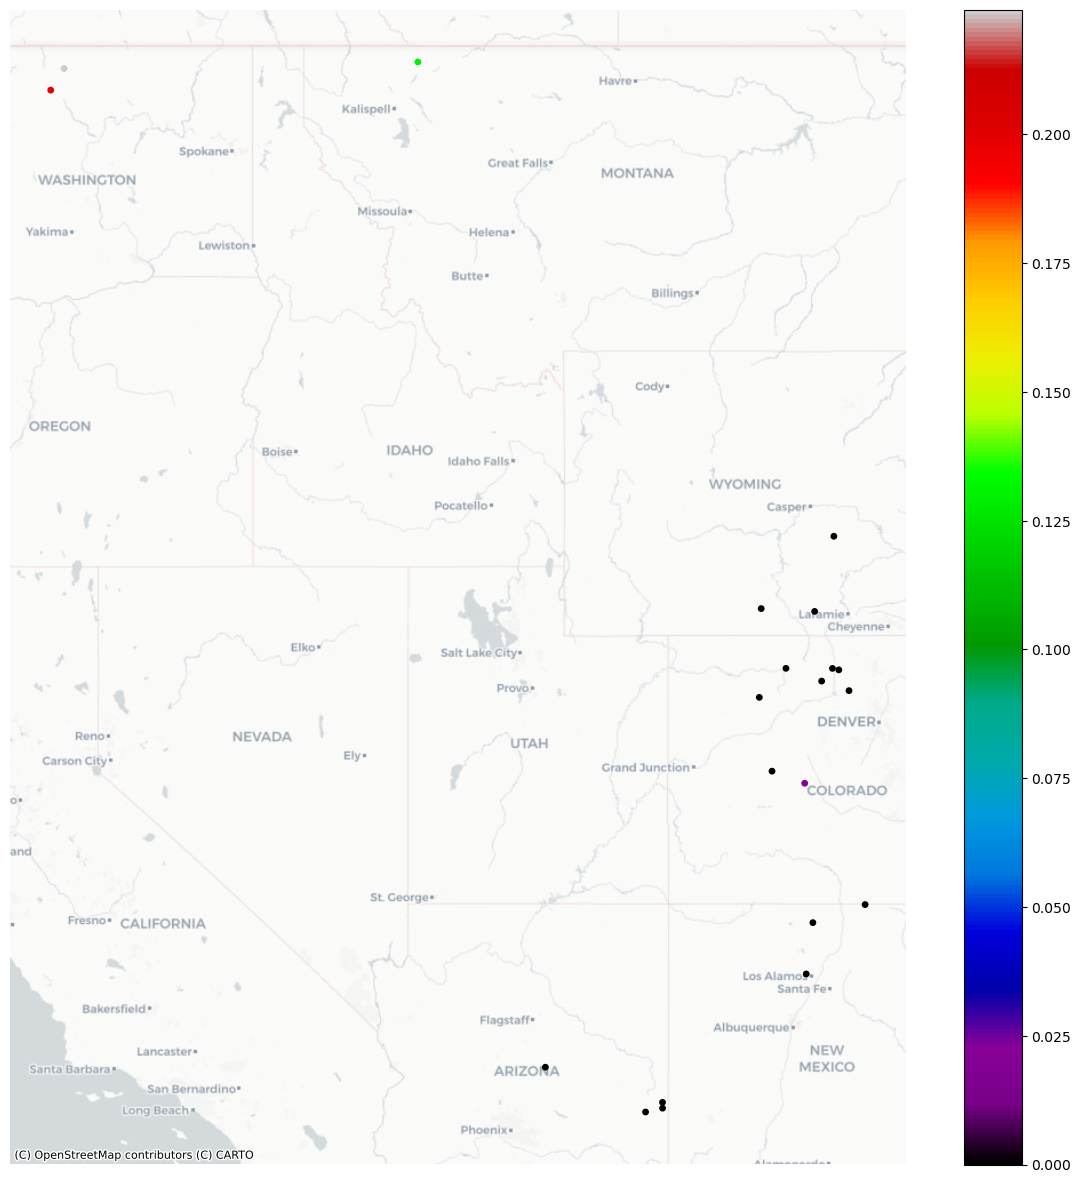

In [138]:
# Plot
ax = gdf_us.plot(
    "rsds",
    figsize=(15, 15),
    alpha=1,
    markersize=15,
    legend=True,
    cmap="nipy_spectral",
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()